In [1]:
import numpy as np
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

from utils.jax_ops import (
    MPS,
    contract_MPS,
    compress_MPS,
    add_MPS_MPS,
    multiply_MPS_MPS,
    list_to_jnp,
    list_to_np,
    apply_MPO,
    bond_dims_of_MPS,
    phys_dims_of_MPS,
)
from utils.mpos import kron_delta, toeplitz4_cores

In [2]:
n = 10
max_bond = 5

In [3]:
### Macroscopic Quantities ###


# define c_i
c_left = -1  # c_0
c_mid = 0  # c_1
c_right = 1  # c_2

# some utilities
unit_mps = [jnp.ones((1, 2, 1)) for i in range(n)]
kron = jnp.array(kron_delta(2))


# density
def calc_rho(left, mid, right):
    sum = left[:]
    sum = add_MPS_MPS(sum, mid)
    sum = add_MPS_MPS(sum, right)
    sum = compress_MPS(sum, max_bond=max_bond)
    return sum


# velocity
def calc_rho_u(left, mid, right):
    rho = calc_rho(left, mid, right)
    # NOTE: this is BAD! possible solution: cross approximation, working on a jax-based implementation. A workaround would be better!
    rho_inv = MPS(1 / contract_MPS(rho))
    sum = left[:]
    sum[0] = c_left * sum[0]
    sum = add_MPS_MPS(
        sum, right
    )  # actually c_right * right, but its 1, so we can skip that step
    sum = compress_MPS(sum, max_bond=max_bond)
    sum = multiply_MPS_MPS(kron, rho_inv, sum)
    sum = compress_MPS(sum, max_bond=max_bond)
    return rho, sum

In [4]:
### colision step ###


# equilibrium terms
def calc_f_eq(
    w, coeff, left, mid, right
):  # w[i] are the weights, coeff[j] are the coefficients of the Taylor terms
    rho, u = calc_rho_u(left, mid, right)
    u_squared = multiply_MPS_MPS(kron, u, u)

    # left side
    left_eq = u_squared[:]
    left_eq[0] = coeff[2] * left_eq[0]
    temp = u_squared[:]
    temp[0] = coeff[1] * c_left**2 * temp[0]
    left_eq = add_MPS_MPS(temp, left_eq)
    temp = u[:]
    temp[0] = coeff[0] * c_left * temp[0]
    left_eq = add_MPS_MPS(temp, left_eq)
    left_eq = add_MPS_MPS(unit_mps, left_eq)
    left_eq = compress_MPS(left_eq, max_bond=max_bond)
    left_eq = multiply_MPS_MPS(kron, rho, left_eq)
    left_eq = compress_MPS(left_eq, max_bond=max_bond)
    left_eq[0] = w[0] * left_eq[0]

    # middle
    mid_eq = u_squared[:]
    mid_eq[0] = coeff[2] * mid_eq[0]
    # temp = u_squared                                # this is all lost because of c_mid = 0
    # temp[0] = coeff[1] * c_mid**2 * temp[0]              #
    # mid_eq = add_MPS_MPS(temp, mid_eq)                #
    # temp = u                                        #
    # temp[0] = coeff[0] * c_mid * temp[0]              #
    # mid_eq = add_MPS_MPS(temp, mid_eq)                #
    mid_eq = add_MPS_MPS(unit_mps, mid_eq)
    mid_eq = compress_MPS(mid_eq, max_bond=max_bond)
    mid_eq = multiply_MPS_MPS(kron, rho, mid_eq)
    mid_eq = compress_MPS(mid_eq, max_bond=max_bond)
    mid_eq[0] = w[1] * mid_eq[0]

    # right side
    right_eq = u_squared[:]
    right_eq[0] = coeff[2] * right_eq[0]
    temp = u_squared[:]
    temp[0] = coeff[1] * c_right**2 * temp[0]
    right_eq = add_MPS_MPS(temp, right_eq)
    temp = u[:]
    temp[0] = coeff[0] * c_right * temp[0]
    right_eq = add_MPS_MPS(temp, right_eq)
    right_eq = add_MPS_MPS(unit_mps, right_eq)
    right_eq = compress_MPS(right_eq, max_bond=max_bond)
    right_eq = multiply_MPS_MPS(kron, rho, right_eq)
    right_eq = compress_MPS(right_eq, max_bond=max_bond)
    right_eq[0] = w[2] * right_eq[0]

    return left_eq, mid_eq, right_eq


# update step
def calc_f_star(tau, left_eq, mid_eq, right_eq, left, mid, right):

    # left side
    left_star = left[:]
    left_star[0] = -1 * left_star[0]
    left_star = add_MPS_MPS(left_eq, left_star)
    left_star[0] = left_star[0] / tau
    left_star = add_MPS_MPS(left, left_star)
    left_star = compress_MPS(left_star, max_bond=max_bond)

    # mid side
    mid_star = mid[:]
    mid_star[0] = -1 * mid_star[0]
    mid_star = add_MPS_MPS(mid_eq, mid_star)
    mid_star[0] = mid_star[0] / tau
    mid_star = add_MPS_MPS(mid, mid_star)
    mid_star = compress_MPS(mid_star, max_bond=max_bond)

    # right side
    right_star = right[:]
    right_star[0] = -1 * right_star[0]
    right_star = add_MPS_MPS(right_eq, right_star)
    right_star[0] = right_star[0] / tau
    right_star = add_MPS_MPS(right, right_star)
    right_star = compress_MPS(right_star, max_bond=max_bond)

    return left_star, mid_star, right_star

In [5]:
### streaming step ###


# shift MPOs
shift_left = list_to_jnp(toeplitz4_cores([0, 1, 0, 0, 0, 0, 0, 0, 0], n))
shift_right = list_to_jnp(toeplitz4_cores([0, 0, 0, 0, 0, 0, 0, 0, 1], n))


# update step
def calc_f_next(left_star, mid_star, right_star):
    # shift to the left
    left_next = apply_MPO(shift_left, left_star)
    left_next = compress_MPS(left_next, max_bond=max_bond)

    # mid stays the same
    mid_next = mid_star

    # shift to the right
    right_next = apply_MPO(shift_right, right_star)
    right_next = compress_MPS(right_next, max_bond=max_bond)

    return left_next, mid_next, right_next

In [6]:
### Boundaries ###


# swapping of directions on boundaries
def calc_boundaries(obstacles_sign, left_next, mid_next, right_next):
    sum = add_MPS_MPS(left_next, right_next)
    sum = compress_MPS(sum, max_bond=max_bond)
    temp = right_next[:]
    temp[0] = -1 * temp[0]
    dif = add_MPS_MPS(left_next, temp)
    swapped_dif = multiply_MPS_MPS(kron, obstacles_sign, dif)
    swapped_dif = compress_MPS(swapped_dif, max_bond=max_bond)
    neg_swapped_dif = swapped_dif[:]
    neg_swapped_dif[0] = -1 * neg_swapped_dif[0]

    left_swap = add_MPS_MPS(sum, swapped_dif)
    left_swap = compress_MPS(left_swap, max_bond=max_bond)
    left_swap[0] = 0.5 * left_swap[0]
    mid_swap = mid_next
    right_swap = add_MPS_MPS(sum, neg_swapped_dif)
    right_swap = compress_MPS(right_swap, max_bond=max_bond)
    right_swap[0] = 0.5 * right_swap[0]
    return left_swap, mid_swap, right_swap

In [7]:
### time step ###


def advance_time(w, coeff, tau, obstacles_sign, left, mid, right):
    left_eq, mid_eq, right_eq = calc_f_eq(w, coeff, left, mid, right)
    left_star, mid_star, right_star = calc_f_star(
        tau, left_eq, mid_eq, right_eq, left, mid, right
    )
    left_next, mid_next, right_next = calc_f_next(left_star, mid_star, right_star)
    left_swap, mid_swap, right_swap = calc_boundaries(
        obstacles_sign, left_next, mid_next, right_next
    )
    return left_swap, mid_swap, right_swap

In [8]:
# Define Gaussian and sine function
def gaussian(x, mu, sigma):
    return np.exp(
        -0.5 * ((x - mu) / sigma) ** 2
    )  # * (1 / (sigma * np.sqrt(2 * np.pi)))


def sine_squared(x, mu, offset):
    return np.sin(2 * np.pi * (x_values - mu)) ** 2 + offset


# resolution
N = 2**n
vec_shape = 2**n
mps_shape = (2,) * n

# x values from 0 to 1
x_values = np.linspace(0, 1, N)

# Mean (peak) in the middle
mu = 0.5

# linear velocity offset
offset = 0.5

# Standard deviation (adjust for desired width)
sigma = 0.05

# Generate Arrays with initial values
gauss_initial = 1 + gaussian(x_values, mu, sigma).reshape(mps_shape)
sin_initial = sine_squared(x_values, mu, offset).reshape(mps_shape)
zero_initial = np.zeros(N).reshape(mps_shape)

In [9]:
w = [1 / 6, 4 / 6, 1 / 6]
coeff = [3, 9 / 2, -3 / 2]
tau = 10
steps = 5 * N

vec_shape = 2**n
mps_shape = (2,) * n

left = MPS(zero_initial, max_bond=max_bond)  # f_0
mid = MPS(gauss_initial, max_bond=max_bond)  # f_1
right = MPS(zero_initial, max_bond=max_bond)  # f_2

obstacles = jnp.zeros(N).at[int(8 / 10 * N) : int(9 / 10 * N)].set(1).reshape(mps_shape)
obstacles_sign = -2 * obstacles + 1
obstacles = MPS(obstacles, max_bond=max_bond)
obstacles_sign = MPS(obstacles_sign, max_bond=max_bond)

jit_adv_time = jax.jit(advance_time)

In [10]:
### compression ###
ratio = sum([t.size for t in left]) / N
print(ratio)

0.3125


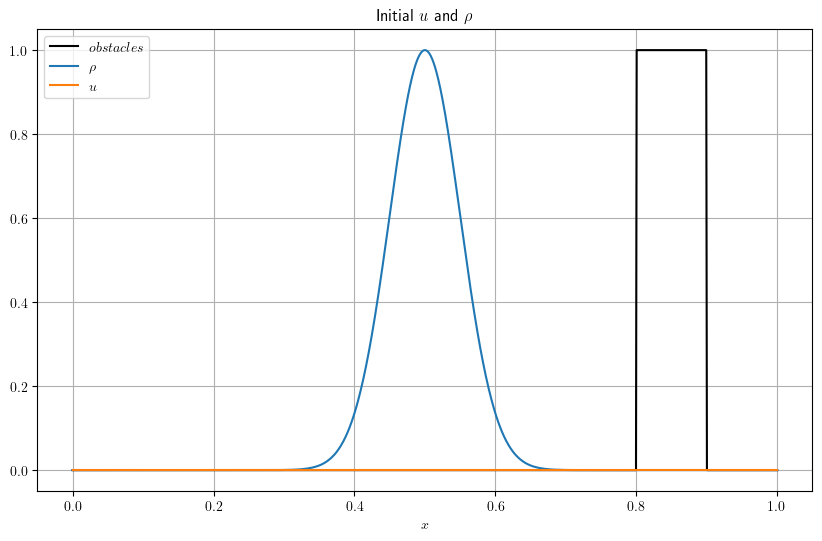

In [11]:
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True

rho, u = calc_rho_u(left, mid, right)
rho_initial = contract_MPS(rho).reshape(vec_shape) - 1
u_initial = contract_MPS(u).reshape(vec_shape)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(
    x_values,
    contract_MPS(obstacles).reshape(vec_shape),
    label=r"$obstacles$",
    color="black",
)
plt.plot(x_values, rho_initial, label=r"$\rho$")
plt.plot(x_values, u_initial, label=r"$u$")

# Customize the plot
plt.xlabel(r"$x$")
plt.title(r"Initial $u$ and $\rho$")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [12]:
data = []
rho, u = calc_rho_u(left, mid, right)
rho, u = contract_MPS(rho).reshape(vec_shape) - 1, contract_MPS(u).reshape(vec_shape)
data.append([rho, u])

In [13]:
left, mid, right = jit_adv_time(w, coeff, tau, obstacles_sign, left, mid, right)

In [14]:
clip_length = 5
fps = 30
interval = 1e3 / fps
frames_necessary = clip_length * fps

for i in range(2, steps):
    left, mid, right = jit_adv_time(w, coeff, tau, obstacles_sign, left, mid, right)
    if i % int(steps / frames_necessary) == 0:
        rho, u = calc_rho_u(left, mid, right)
        rho, u = contract_MPS(rho).reshape(vec_shape) - 1, contract_MPS(u).reshape(
            vec_shape
        )
        data.append([rho, u])
        print("at", int(100 * i / steps), "percent", end="\r")
print("finished!              ", end="\r")

In [15]:
import matplotlib.animation as animation
from IPython.display import HTML

# Create the animation
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([-0.5, 1.1])
plt.plot(
    x_values,
    contract_MPS(obstacles).reshape(vec_shape),
    label=r"$obstacles$",
    color="black",
)

(line1,) = ax.plot(x_values, data[0][0], label=r"$\rho$")
(line2,) = ax.plot(x_values, data[0][1], label=r"$u$")


def animate(i):
    line1.set_ydata(data[i][0])  # Update the data
    line2.set_ydata(data[i][1])  # Update the data
    return line1, line2


ani = animation.FuncAnimation(
    fig, animate, frames=len(data), blit=True, interval=interval, repeat=False
)

plt.xlabel(r"$x$")
plt.legend()
plt.grid(True)
plt.title(
    r"MPS Solution with $\frac{|MPS|}{|Array|}$ $\approx$ " + str(np.round(ratio, 1))
)
plt.close()

# render the animation
HTML(ani.to_html5_video())